In [1]:
# 필요한 모듈 및 라이브러리를 임포트
import os
import json

import numpy
import pandas

import tensorflow as tf

from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt

from preprocess import *

In [2]:
# 학습 시각화 함수
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [3]:
# 랜덤 시드값
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [4]:
# 학습 데이터의 경로
DATA_IN_PATH = './data/'
DATA_OUT_PATH = './check_point/'
TRAIN_INPUTS = 'train_inputs.npy'
TRAIN_OUTPUTS = 'train_outputs.npy'
TRAIN_TARGETS = 'train_targets.npy'
DATA_CONFIGS = 'data_configs.json'

# 미리 전처리된 학습에 필요한 데이터와 설정값을 불러옴
index_inputs = np.load(open(DATA_IN_PATH + TRAIN_INPUTS, 'rb'))
index_outputs = np.load(open(DATA_IN_PATH + TRAIN_OUTPUTS , 'rb'))
index_targets = np.load(open(DATA_IN_PATH + TRAIN_TARGETS , 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [5]:
# 모델 하이퍼파라미터
MODEL_NAME = 'seq2seq_kr'
BATCH_SIZE = 16
MAX_SEQUENCE = 25
EPOCHS = 30
ENC_UNITS = 128
DEC_UNITS = 128
EMBEDDING_DIM = 64
VALID_SPLIT = 0.1

char2idx = prepro_configs['char2idx']
idx2char = prepro_configs['idx2char']
std_index = prepro_configs['std_symbol']
end_index = prepro_configs['end_symbol']
vocab_size = prepro_configs['vocab_size']

In [6]:
# Encoder
class Encoder(Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_size):
        super(Encoder, self).__init__()
        self.batch_size = batch_size
        self.enc_units = enc_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        # 단어를 emdding_dim차원의 임베딩 벡터로 만든다
        self.embedding = Embedding(self.vocab_size, self.embedding_dim)
        # 재귀 신경망(GRU)
        self.gru = GRU(self.enc_units, return_sequences=True,
                      return_state=True, recurrent_initializer='glorot_uniform')
    
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state=hidden)
        
        return output, state
    
    def initialize_hidden_state(self, inp):
        return tf.zeros((tf.shape(inp)[0], self.enc_units))

In [7]:
# 어텐션 가중치를 이용해 디코더에 전달할 새로운 GRU의 결괏값을 만든다
class BahdanauAttention(Layer):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        
        # 출력 벡터의 크기(units)를 인자로 받아 W1,W2,V의 완전 연결 계층(FC)를 만든다
        self.W1 = Dense(units)
        self.W2 = Dense(units)
        self.V  = Dense(1)
        
    # query: Encoder GRU의 은닉층의 상태 값, values: Encoder GRU의 결괏값 
    def call(self, query, values):
        # query를 W2에 행렬곱을 할 수 있는 형태로 만든다
        hidden_with_time_axis = tf.expand_dims(query, 1)
        # W1과 W2의 결괏값의 요소를 각각 더하고 활성함수를 통과한 값을 V에 행렬곱하여 1차원의 벡터값을 만든다.
        score = self.V(tf.nn.tanh(
                        self.W1(values) + self.W2(hidden_with_time_axis)))
        
        # 이 값을 softmax에 넣어 어텐션 가중치를 얻는다
        # attention_weights는 모델이 중요하다고 판단하는 값은 1에 가까워지고 중요하지 않다고 판단할 수록 0에 가까워지는 값
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # 위에서 구한 어텐션 가중치에 GRU 결괏값인 values를 행렬 곱을 하면,
        # 1에 가까운 값에 위치한 value값(모델이 중요하다고 판단하는 값)은 커지고, 0에 가까운 값에 위치한 value값(모델이 중요치 않다고 판단하는 값)은 작아진다
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        return context_vector, attention_weights

In [8]:
# Decoder
class Decoder(Layer):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_size):
        super(Decoder, self).__init__()
        
        self.batch_size = batch_size
        self.dec_units = dec_units
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        
        self.embedding = Embedding(self.vocab_size, self.embedding_dim)
        self.gru = GRU(self.dec_units, return_sequences=True,
                      return_state=True, recurrent_initializer='glorot_uniform')
        self.fc = Dense(self.vocab_size)
        
        self.attention = BahdanauAttention(self.dec_units)
        
    # hidden: Enocder의 은닉 상태 값, enc_output: Encoder의 결괏값
    def call(self, x, hidden, enc_output):
        context_vector, attention_weights = self.attention(hidden, enc_output)
        
        x = self.embedding(x)
        
        # 임베딩 벡터 x와 어텐션 가중치를 곱한 context_vector를 결합해 다시 x를 구성
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # GRU를 통과시한 결괏값을 완전 연결 계층(FC)에 연결해 사전 크기의 벡터 x를 만든다
        output, state = self.gru(x)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        x = self.fc(output)
        
        return x, state, attention_weights

In [9]:
# 손실 함수, 정확도 측정 함수
# 최적화 객체
optimizer = 'adam'
# 손실 값을 측정하기 위한 객체
loss_object = SparseCategoricalCrossentropy(from_logits=True, reduction='none')
# 정확도 측정을 위한 객체
train_accuracy = SparseCategoricalAccuracy(name='accuracy')

# 손실 함수
def loss(real, pred):
    # mask= real값 중 0인 값(<PAD>)를 제외
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    
    return tf.reduce_mean(loss_)

# 정확도 측정 함수
def accuracy(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    mask = tf.expand_dims(tf.cast(mask, dtype=pred.dtype), axis=-1)
    pred *= mask
    acc = train_accuracy(real, pred)
    
    return tf.reduce_mean(acc)

In [28]:
# seq2seq 모델
class seq2seq(Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, dec_units, batch_size, end_token_idx=2):
        super(seq2seq, self).__init__()
        self.end_token_idx = end_token_idx
        self.encoder = Encoder(vocab_size, embedding_dim, enc_units, batch_size)
        self.decoder = Decoder(vocab_size, embedding_dim, dec_units, batch_size)
        
    def call(self, x):
        inp, tar = x
        
        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)
        
        dec_hidden = enc_hidden
        
        # predict_tokens= 시퀀스마다 나온 결괏값, 손실 또는 정확도를 계산하는 용도로 사용
        predict_tokens = list()
        for t in range(0, tar.shape[1]):
            dec_input = tf.dtypes.cast(tf.expand_dims(tar[:, t], 1), tf.float32)
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_tokens.append(tf.dtypes.cast(predictions, tf.float32))
            
        return tf.stack(predict_tokens, axis=1)
    
    # 사용자의 입력에 대한 결과를 확인하기 위해, 테스트 목적의 프로토콜 함수
    def inference(self, x):
        inp = x
        
        enc_hidden = self.encoder.initialize_hidden_state(inp)
        enc_output, enc_hidden = self.encoder(inp, enc_hidden)
        
        dec_hidden = enc_hidden
        
        dec_input = tf.expand_dims([char2idx[std_index]], 1)
        
        predict_tokens = list()
        for t in range(0, MAX_SEQUENCE):
            predictions, dec_hidden, _ = self.decoder(dec_input, dec_hidden, enc_output)
            predict_token = tf.argmax([predictions[0]])
            
            # <END> 토큰을 만나면 정지, 하나의 배치에 대해서만 동작
            if predict_token == self.end_token_idx:
                break
            
            predict_tokens.append(predict_token)
            dec_input = tf.dtypes.caast(tf.expand_dims[[predict_tolken], 0], tf.float32)
            
        return tf.stack(predict_tokens, axis=0).numpy()

In [11]:
# seq2seq 모델 생성
model = seq2seq(vocab_size, EMBEDDING_DIM, ENC_UNITS, DEC_UNITS,
               BATCH_SIZE, char2idx[end_index])
model.compile(loss=loss, optimizer=optimizer, metrics=[accuracy])

In [12]:
# 모델 체크포인트를 저장하고 과적합을 방지하기 위해 조기 종료를 정의한 함수를 선언
PATH = DATA_OUT_PATH + MODEL_NAME

if os.path.isdir(PATH):
    print(MODEL_NAME + ' Folder already exists!')
    
if not(os.path.isdir(PATH)):
    os.makedirs(os.path.join(PATH))
    print(MODEL_NAME + ' Folder is created!')
    
checkpoint_path = DATA_OUT_PATH + MODEL_NAME + '/weights.h5'

cp_callback = ModelCheckpoint(checkpoint_path,
                             monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)

seq2seq_kr Folder is created!


In [13]:
# 모델 학습
# 현재는 모델이 학습되는지를 빠른 시간 내 검증하기 위해 하이퍼파라미터 값을 조정하여 실행
# 1epoch당 2:30 소요, 30epoch 시 accuracy: 0.8985
history = model.fit([index_inputs, index_outputs], index_targets,
                   batch_size=BATCH_SIZE, epochs=EPOCHS, validation_split=VALID_SPLIT,
                   callbacks=[earlystop_callback, cp_callback])

Epoch 1/30
665/665 [==============================] - ETA: 0s - loss: 1.3159 - accuracy: 0.8557
Epoch 00001: val_accuracy improved from -inf to 0.85309, saving model to ./check_point/seq2seq_kr/weights.h5
665/665 [==============================] - 165s 248ms/step - loss: 1.3159 - accuracy: 0.8557 - val_loss: 1.4926 - val_accuracy: 0.8531
Epoch 2/30
665/665 [==============================] - ETA: 0s - loss: 1.1467 - accuracy: 0.8532
Epoch 00002: val_accuracy did not improve from 0.85309
665/665 [==============================] - 159s 239ms/step - loss: 1.1467 - accuracy: 0.8532 - val_loss: 1.5353 - val_accuracy: 0.8530
Epoch 3/30
665/665 [==============================] - ETA: 0s - loss: 1.0913 - accuracy: 0.8534
Epoch 00003: val_accuracy improved from 0.85309 to 0.85351, saving model to ./check_point/seq2seq_kr/weights.h5
665/665 [==============================] - 160s 241ms/step - loss: 1.0913 - accuracy: 0.8534 - val_loss: 1.5789 - val_accuracy: 0.8535
Epoch 4/30
665/665 [===========

665/665 [==============================] - ETA: 0s - loss: 0.2409 - accuracy: 0.8884
Epoch 00025: val_accuracy improved from 0.88725 to 0.88937, saving model to ./check_point/seq2seq_kr/weights.h5
665/665 [==============================] - 164s 247ms/step - loss: 0.2409 - accuracy: 0.8884 - val_loss: 2.0308 - val_accuracy: 0.8894
Epoch 26/30
665/665 [==============================] - ETA: 0s - loss: 0.2225 - accuracy: 0.8905
Epoch 00026: val_accuracy improved from 0.88937 to 0.89145, saving model to ./check_point/seq2seq_kr/weights.h5
665/665 [==============================] - 166s 249ms/step - loss: 0.2225 - accuracy: 0.8905 - val_loss: 2.0408 - val_accuracy: 0.8914
Epoch 27/30
665/665 [==============================] - ETA: 0s - loss: 0.2048 - accuracy: 0.8925
Epoch 00027: val_accuracy improved from 0.89145 to 0.89349, saving model to ./check_point/seq2seq_kr/weights.h5
665/665 [==============================] - 173s 261ms/step - loss: 0.2048 - accuracy: 0.8925 - val_loss: 2.0661 - v

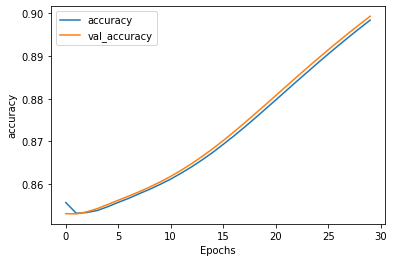

In [14]:
# Epoch에 따른 accuracy 그래프
plot_graphs(history, 'accuracy')

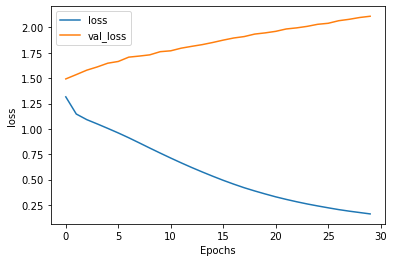

In [15]:
# Epoch에 따른 loss 그래프
plot_graphs(history, 'loss')

In [16]:
# 저장된 모델을 로딩
SAVE_FILE_NAME = 'weights.h5'
model.load_weights(os.path.join(DATA_OUT_PATH, MODEL_NAME, SAVE_FILE_NAME))

In [ ]:
# 챗봇 예시 확인
q = '남자친구 승진 선물로 뭐가 좋을까?'

test_index_inputs, _ = enc_processing([q], char2idx)
predict_tokens = model.inference(test_index_inputs)

print(' '.join([char2word[t] for t in predict_tokens]))
# 평소에 필요했던 게 좋을 것 같아요